In [26]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import binary_dilation
from skimage.morphology import disk
from skimage.draw import disk as draw_disk
from skimage.measure import label
from skimage.measure import block_reduce

### Membrane Extraction

In [33]:
#DILATION METHOD
def extract_membrane(neurons:np.ndarray | str) -> np.ndarray:
    from scipy.ndimage import binary_dilation
    
    neurons = np.load(neurons) if isinstance(neurons, str) else neurons
    
    membrane = np.zeros_like(neurons, dtype=np.uint8)
    for z in range(neurons.shape[0]):
        dilated = binary_dilation(neurons[z], iterations=1)
        membrane[z] = (neurons[z] != dilated).astype(np.uint8) * 255
        
    return membrane

In [34]:
#SOBEL GRADIENT METHOD
def extract_membrane_gradient(neurons):
    """Extract membrane using Sobel gradient (very thin, clean edges)"""
    from scipy.ndimage import sobel
    import numpy as np
    
    # Compute gradients
    sx = sobel(neurons.astype(float), axis=0)
    sy = sobel(neurons.astype(float), axis=1)
    
    # Gradient magnitude
    gradient = np.hypot(sx, sy)
    
    # Binary threshold (membrane where gradient > 0)
    membrane = (gradient > 0).astype(np.uint8) * 255
    
    return membrane

[(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5)),
 (np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5)),
 (np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))]

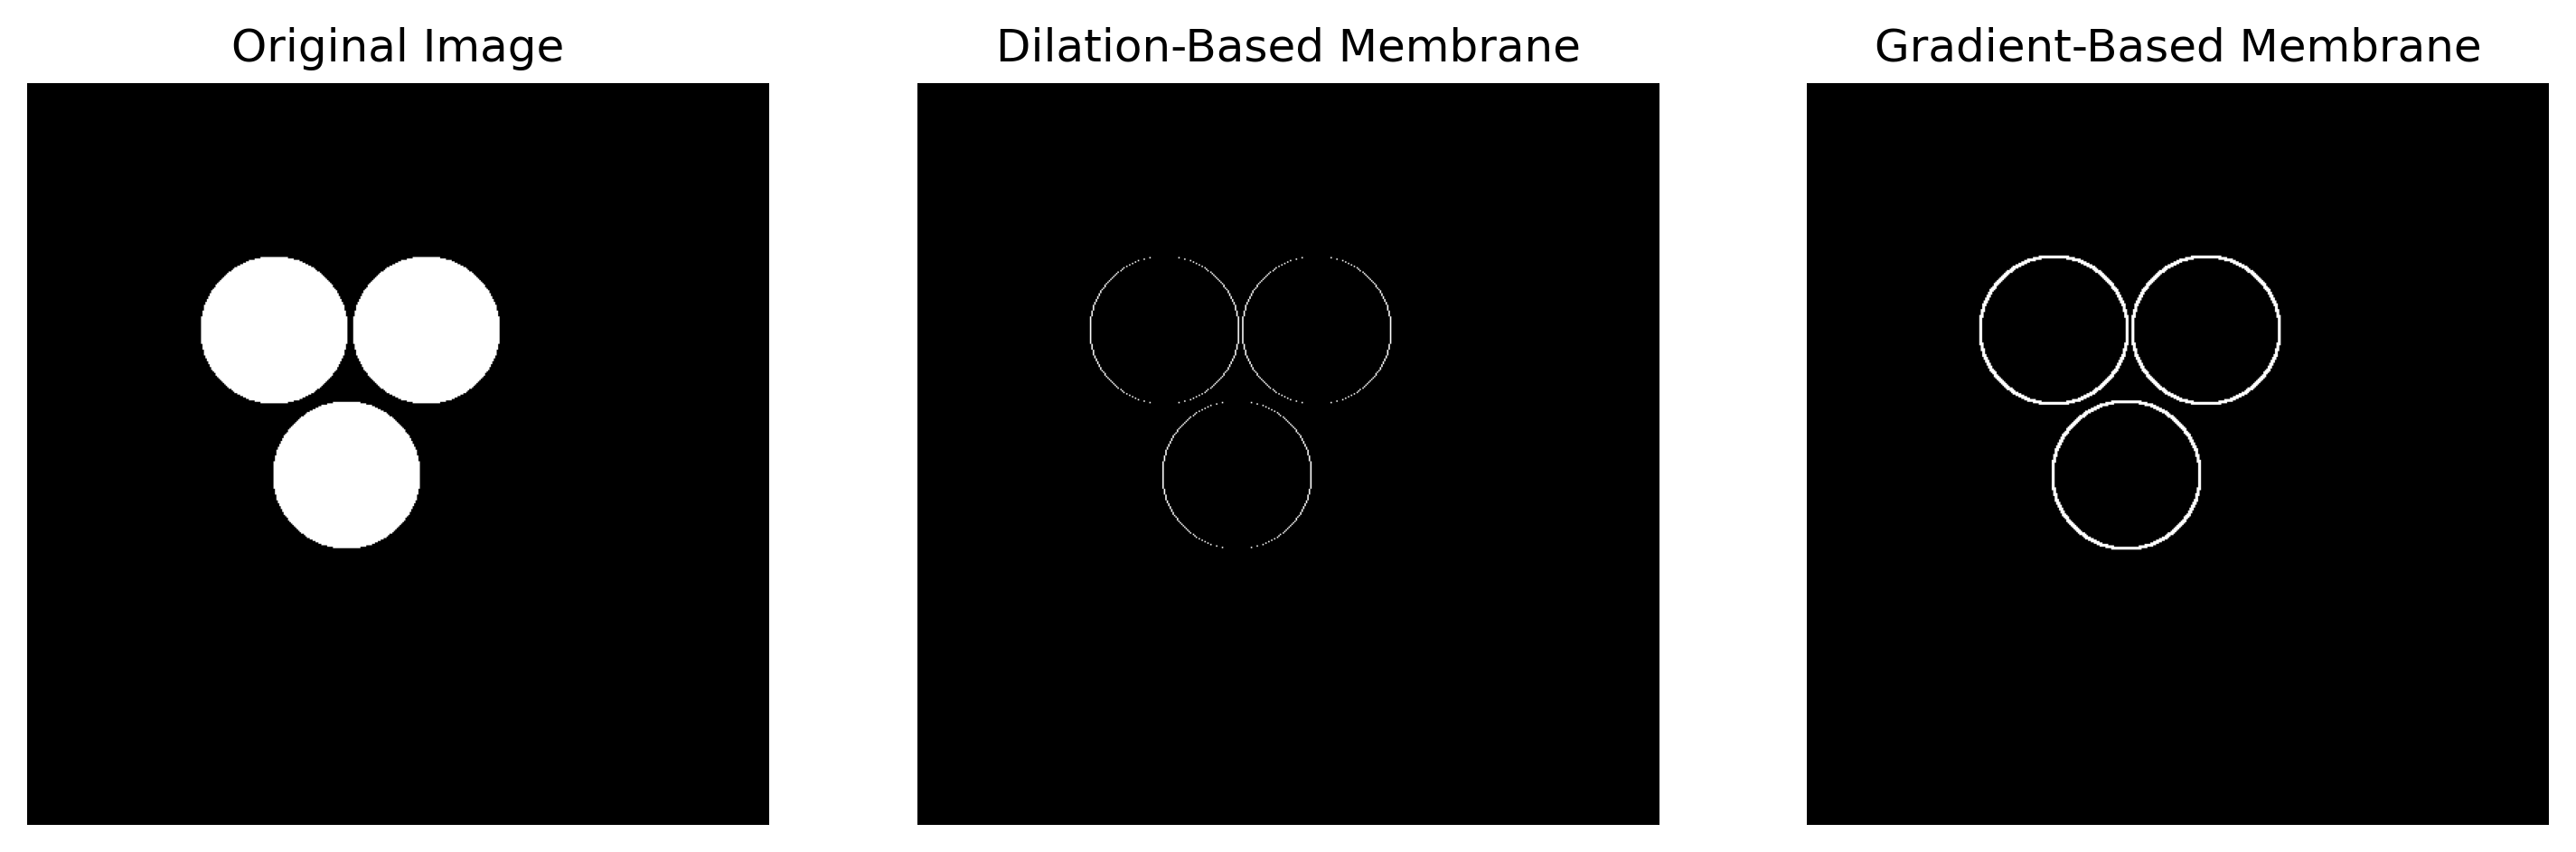

In [46]:
#Generate 3 disks
image = np.zeros((512, 512), dtype=np.uint8)
rr, cc = draw_disk((512//3, 512//3), 50, shape=image.shape)
rr2, cc2 = draw_disk((512//3, 512//3 + 105), 50, shape=image.shape)
rr3, cc3 = draw_disk((512//3 + 100, 512//3 + 50), 50, shape=image.shape)
image[rr, cc] = 255
image[rr2, cc2] = 255
image[rr3, cc3] = 255

#Extract membranes
image = binary_dilation(image, structure=disk(1))
membrane1 = extract_membrane(image)
membrane2 = extract_membrane_gradient(image)

#Plot disks
plt.subplots(1,3, figsize=(12,6), dpi=300)
plt.subplot(131)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.subplot(132)
plt.title("Dilation-Based Membrane")
plt.imshow(membrane1, cmap='gray')
plt.subplot(133)
plt.title("Gradient-Based Membrane")
plt.imshow(membrane2, cmap='gray')
[ax.axis("off") for ax in plt.gcf().axes]

### Contactome Validation

In [ ]:
#Load EM objects
import pandas as pd
neuron_membrane_mask = np.load("/home/tommy111/gap-junction-segmentation/neurons/SEM_adult_neuron_membrane_downsampled4x.npy", mmap_mode='r')
neuron_labels = np.load("/home/tommy111/gap-junction-segmentation/neurons/SEM_adult_neurons_only_with_labels_not_uniform_expanded_block_downsampled4x.npy", mmap_mode='r')

In [3]:
# All neuron ids
all_neuron_labels = np.unique(neuron_labels)
all_neuron_labels = all_neuron_labels[all_neuron_labels > 0].astype(int)

#Initialize connectivity matrix
contactome_matrix = pd.DataFrame(0, index=all_neuron_labels, columns=all_neuron_labels, dtype=np.int32)
gj_connectivity_matrix = pd.DataFrame(0, index=all_neuron_labels, columns=all_neuron_labels, dtype=np.int32)

In [5]:
def _accumulate_undirected_pairs(mat: pd.DataFrame, a: np.ndarray, b: np.ndarray):
        """
        Given two same-length arrays a,b of neuron ids for adjacent pixels,
        accumulate counts into mat symmetrically for undirected pairs.
        """
        if a.size == 0:
            return

        lo = np.minimum(a, b).astype(int, copy=False)
        hi = np.maximum(a, b).astype(int, copy=False)

        pairs = np.stack([lo, hi], axis=1)
        print(pairs)
        uniq_pairs, counts = np.unique(pairs, axis=0, return_counts=True)
        print(uniq_pairs)
        print(counts)

        for (i, j), c in zip(uniq_pairs, counts):
            # i != j always by construction of adjacency mask, but keep safe
            if i == j:
                continue
            mat.at[i, j] += int(c)
            mat.at[j, i] += int(c)

In [ ]:
#Arbitrarily choose a section to test on
z = 250

#Get current slice for all masks
membrane_slice = neuron_membrane_mask[z] > 0
labels_slice = neuron_labels[z].astype(np.int32, copy=False)

# Neuron id at membrane locations, else 0
L = labels_slice * membrane_slice

In [8]:
# Horizontal neighbors
left = L[:, :-1]  # All pixels except the rightmost column
right = L[:, 1:]  # All pixels except the leftmost column

#Get all pixels where two different neurons are touching
m = (left > 0) & (right > 0) & (left != right)

#### Quick Visualization

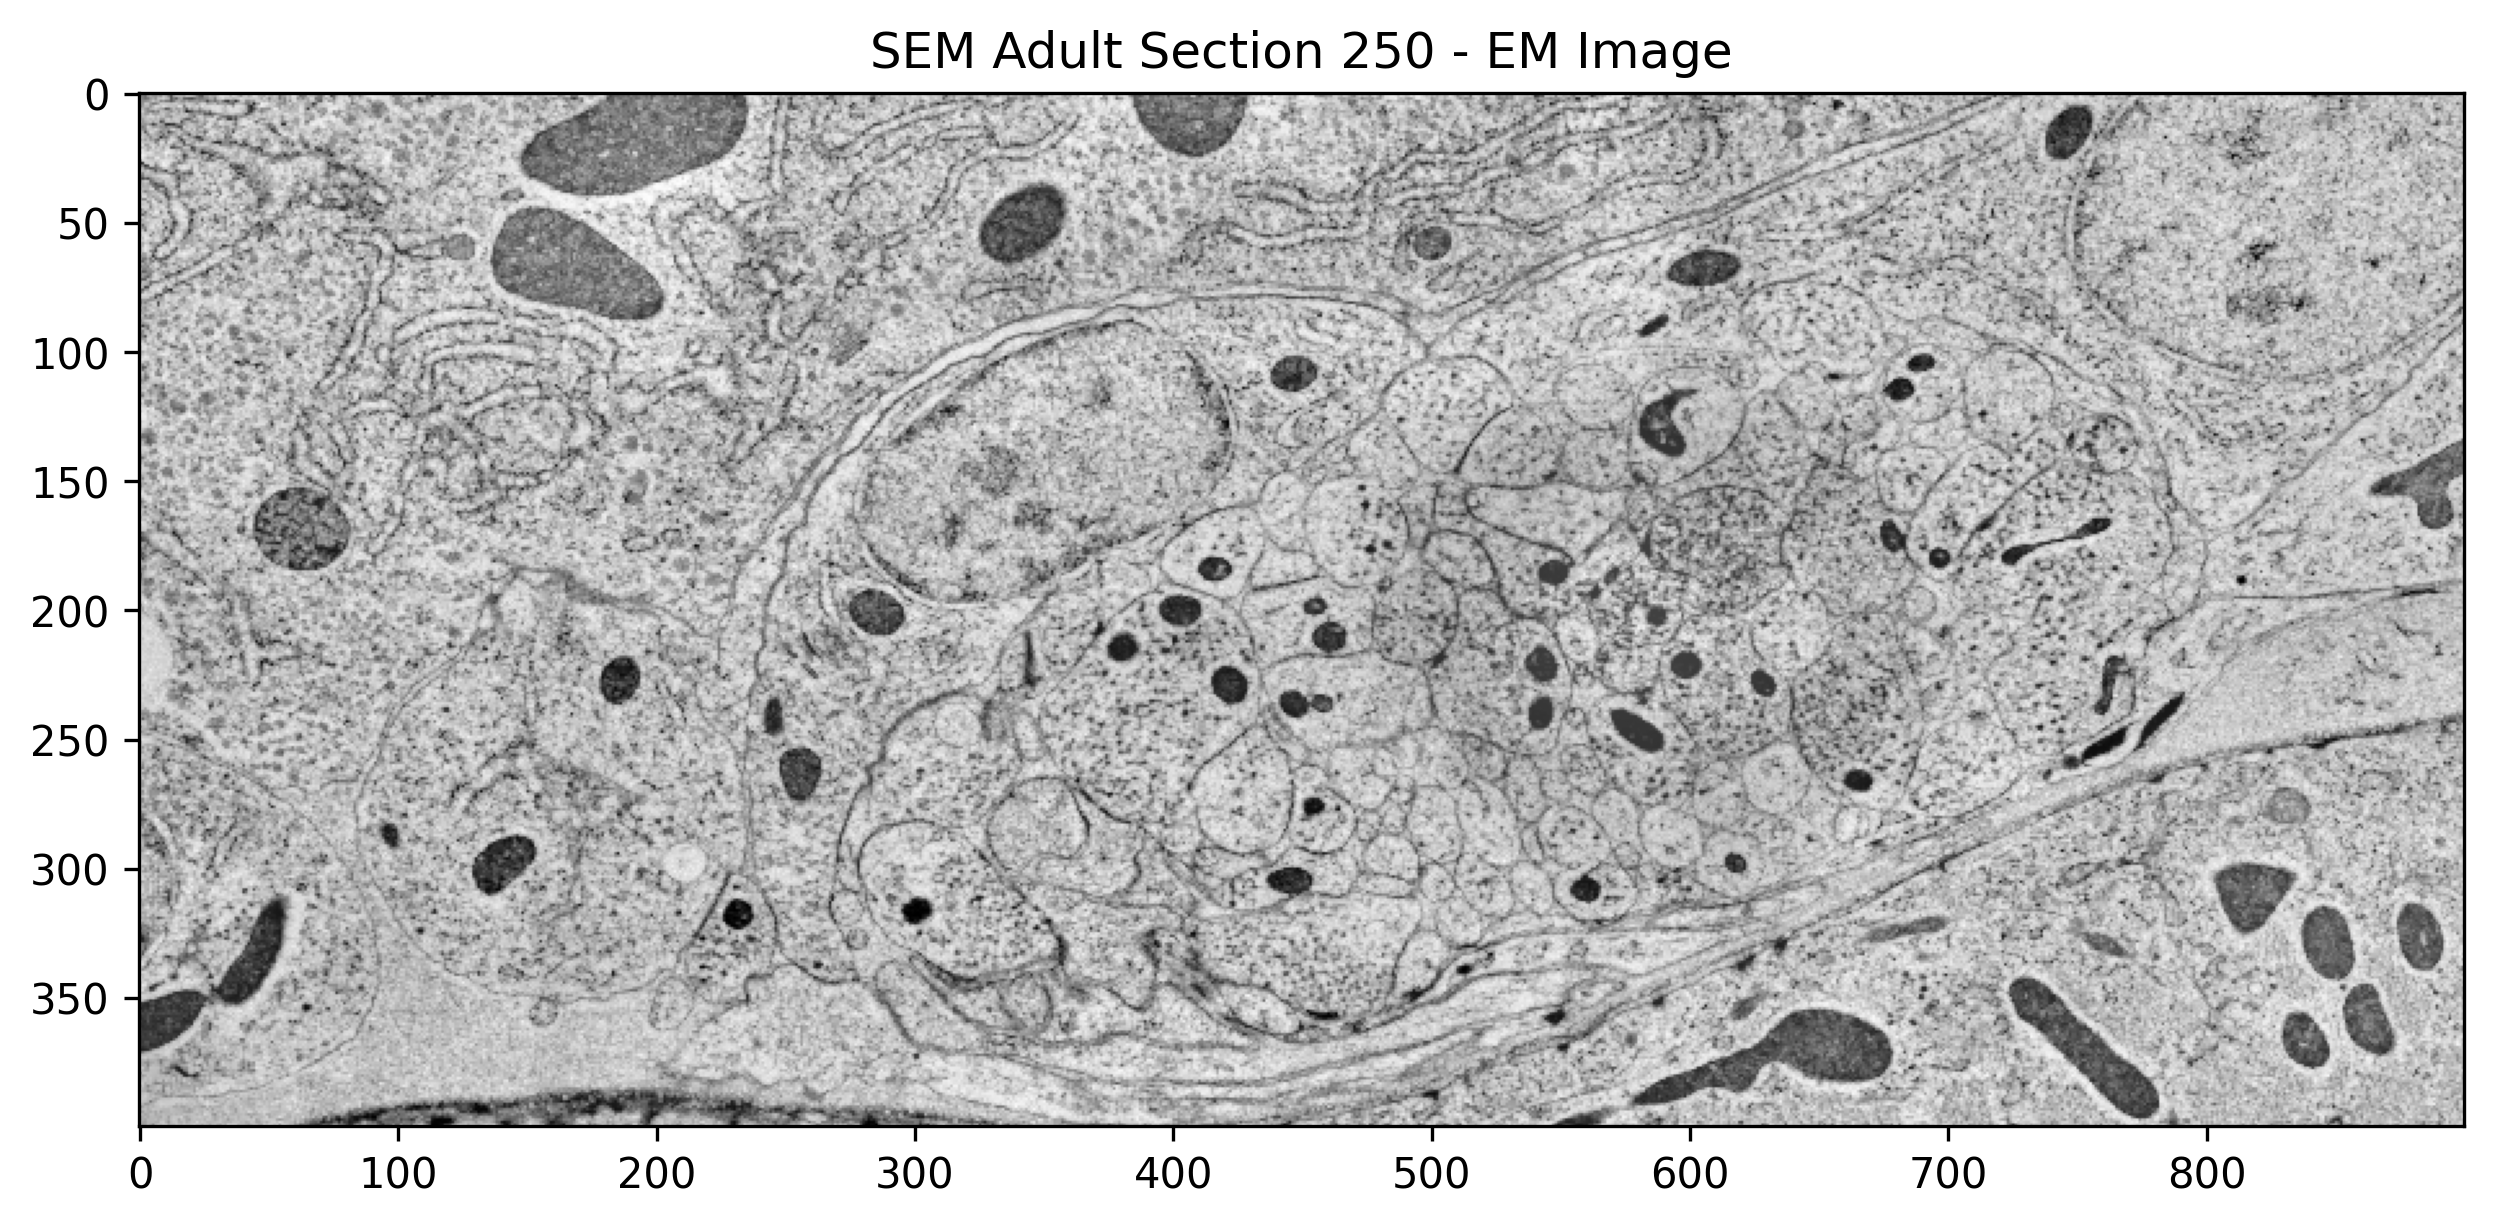

In [35]:
#Original section
s250 = cv2.imread("/mnt/d/Tommy/SEM_adult_larger/Sections/SEM_adult_image_export_s250.png", cv2.IMREAD_GRAYSCALE)
downsampled_array = block_reduce(s250, block_size=(4,4), func=np.max)
plt.figure(figsize=(10,10), dpi=300)
plt.title('SEM Adult Section 250 - EM Image')
plt.imshow(downsampled_array[850:1250, 1700:2600], cmap='gray')

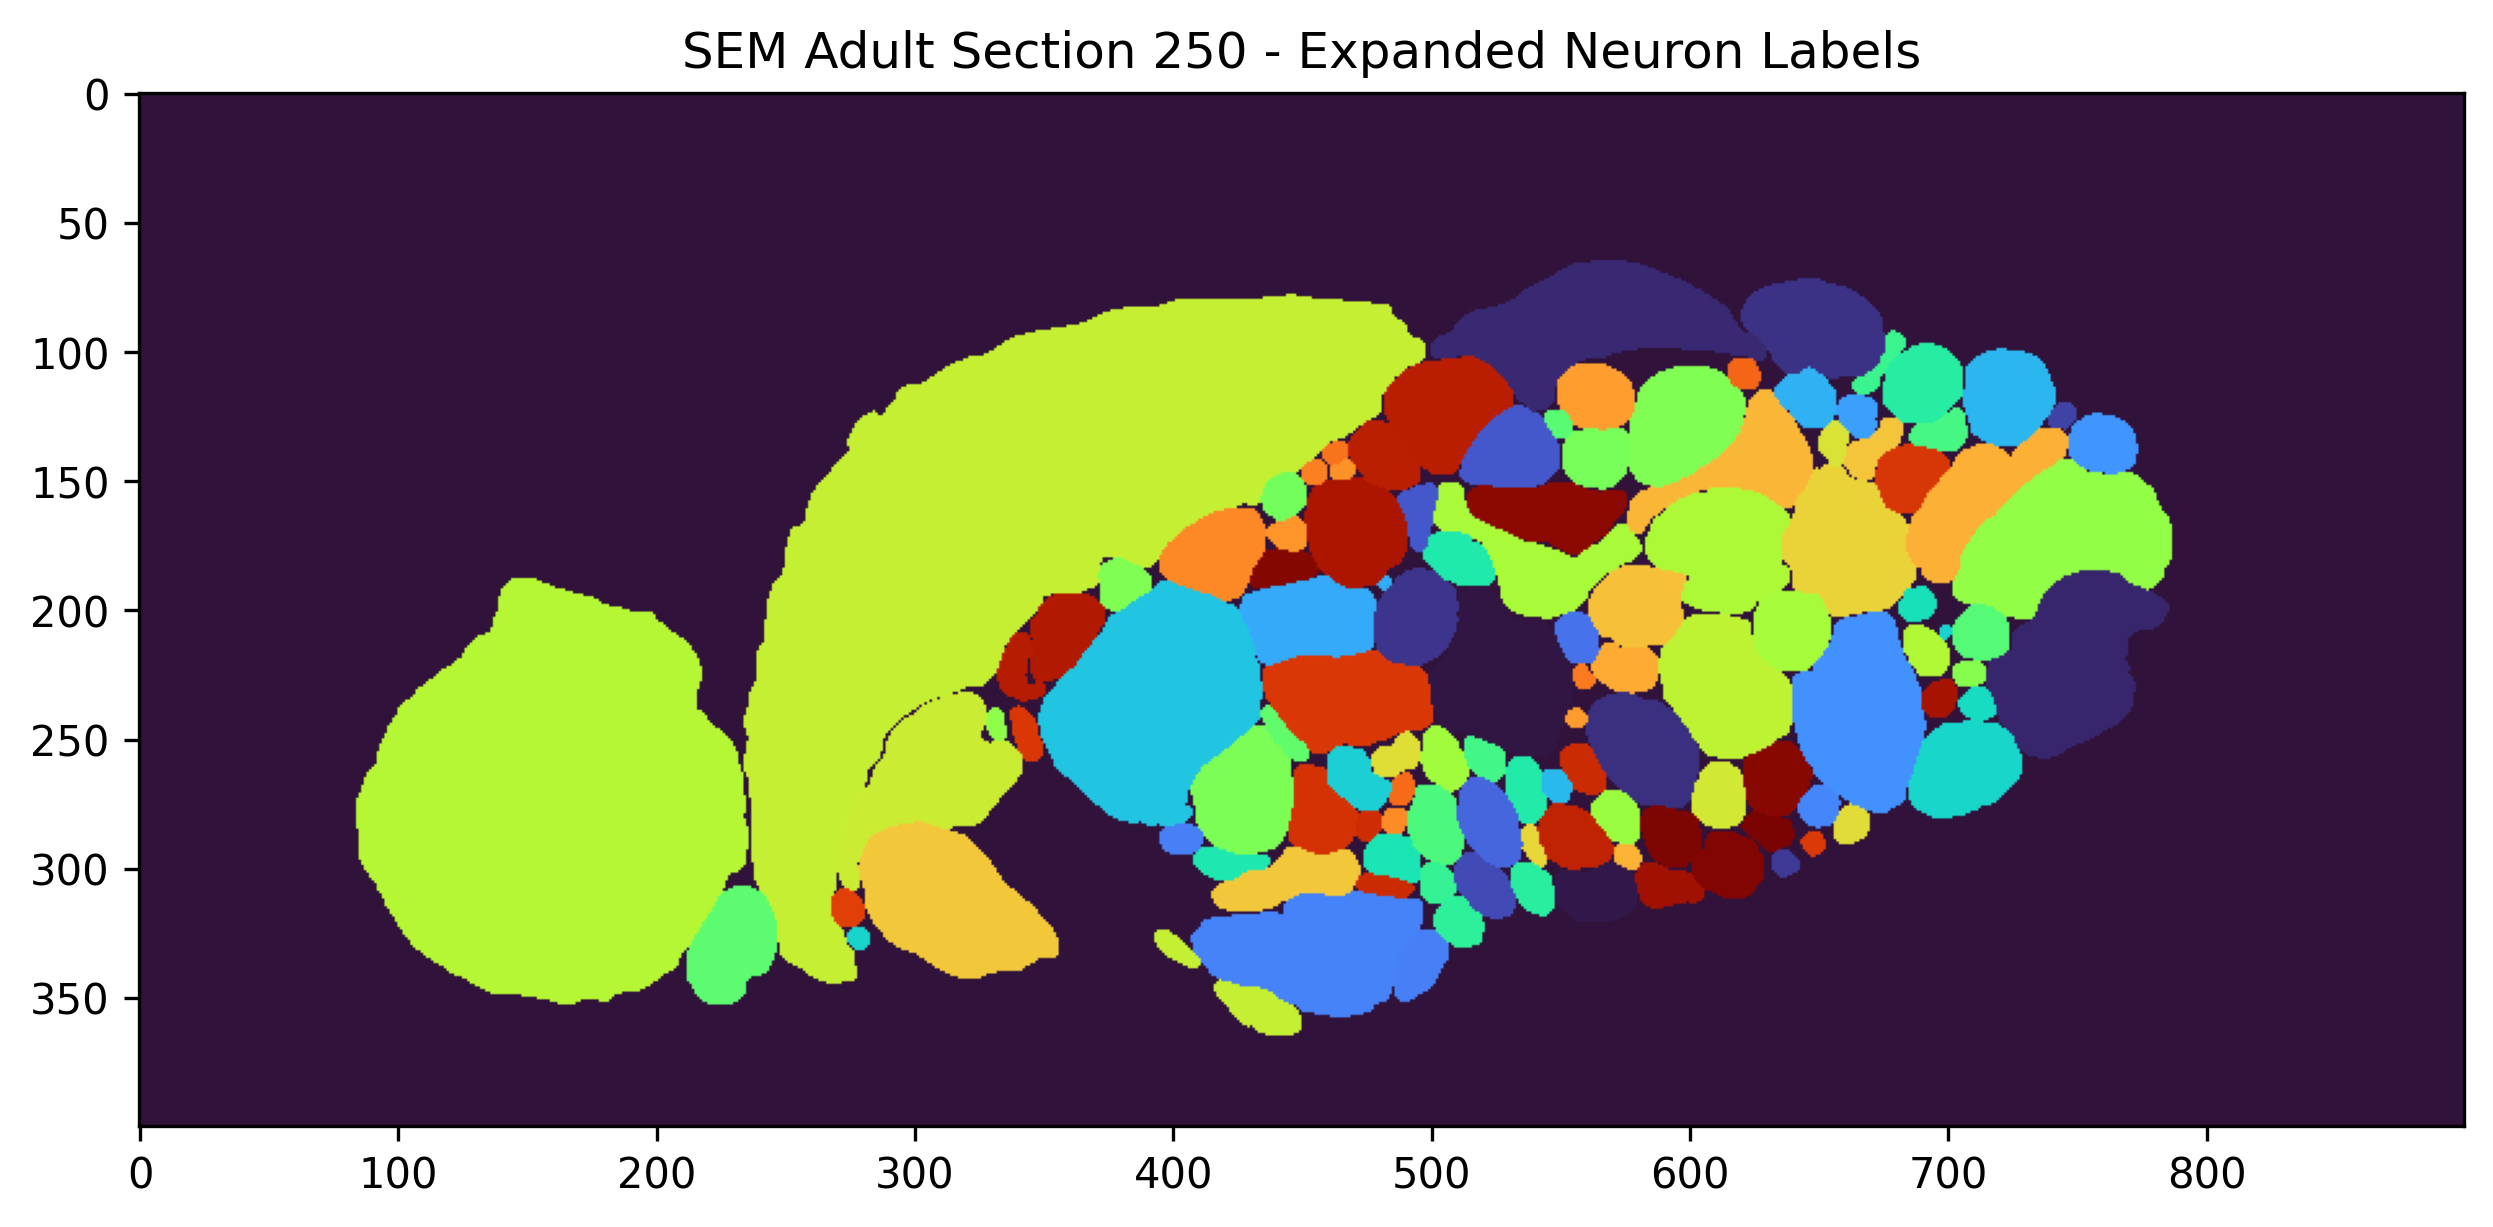

In [ ]:
#Expanded neuron labels
plt.figure(figsize=(10,10), dpi=300)
plt.title('SEM Adult Section 250 - Expanded Neuron Labels')
plt.imshow(neuron_labels[z, 850:1250, 1700:2600], cmap='turbo')

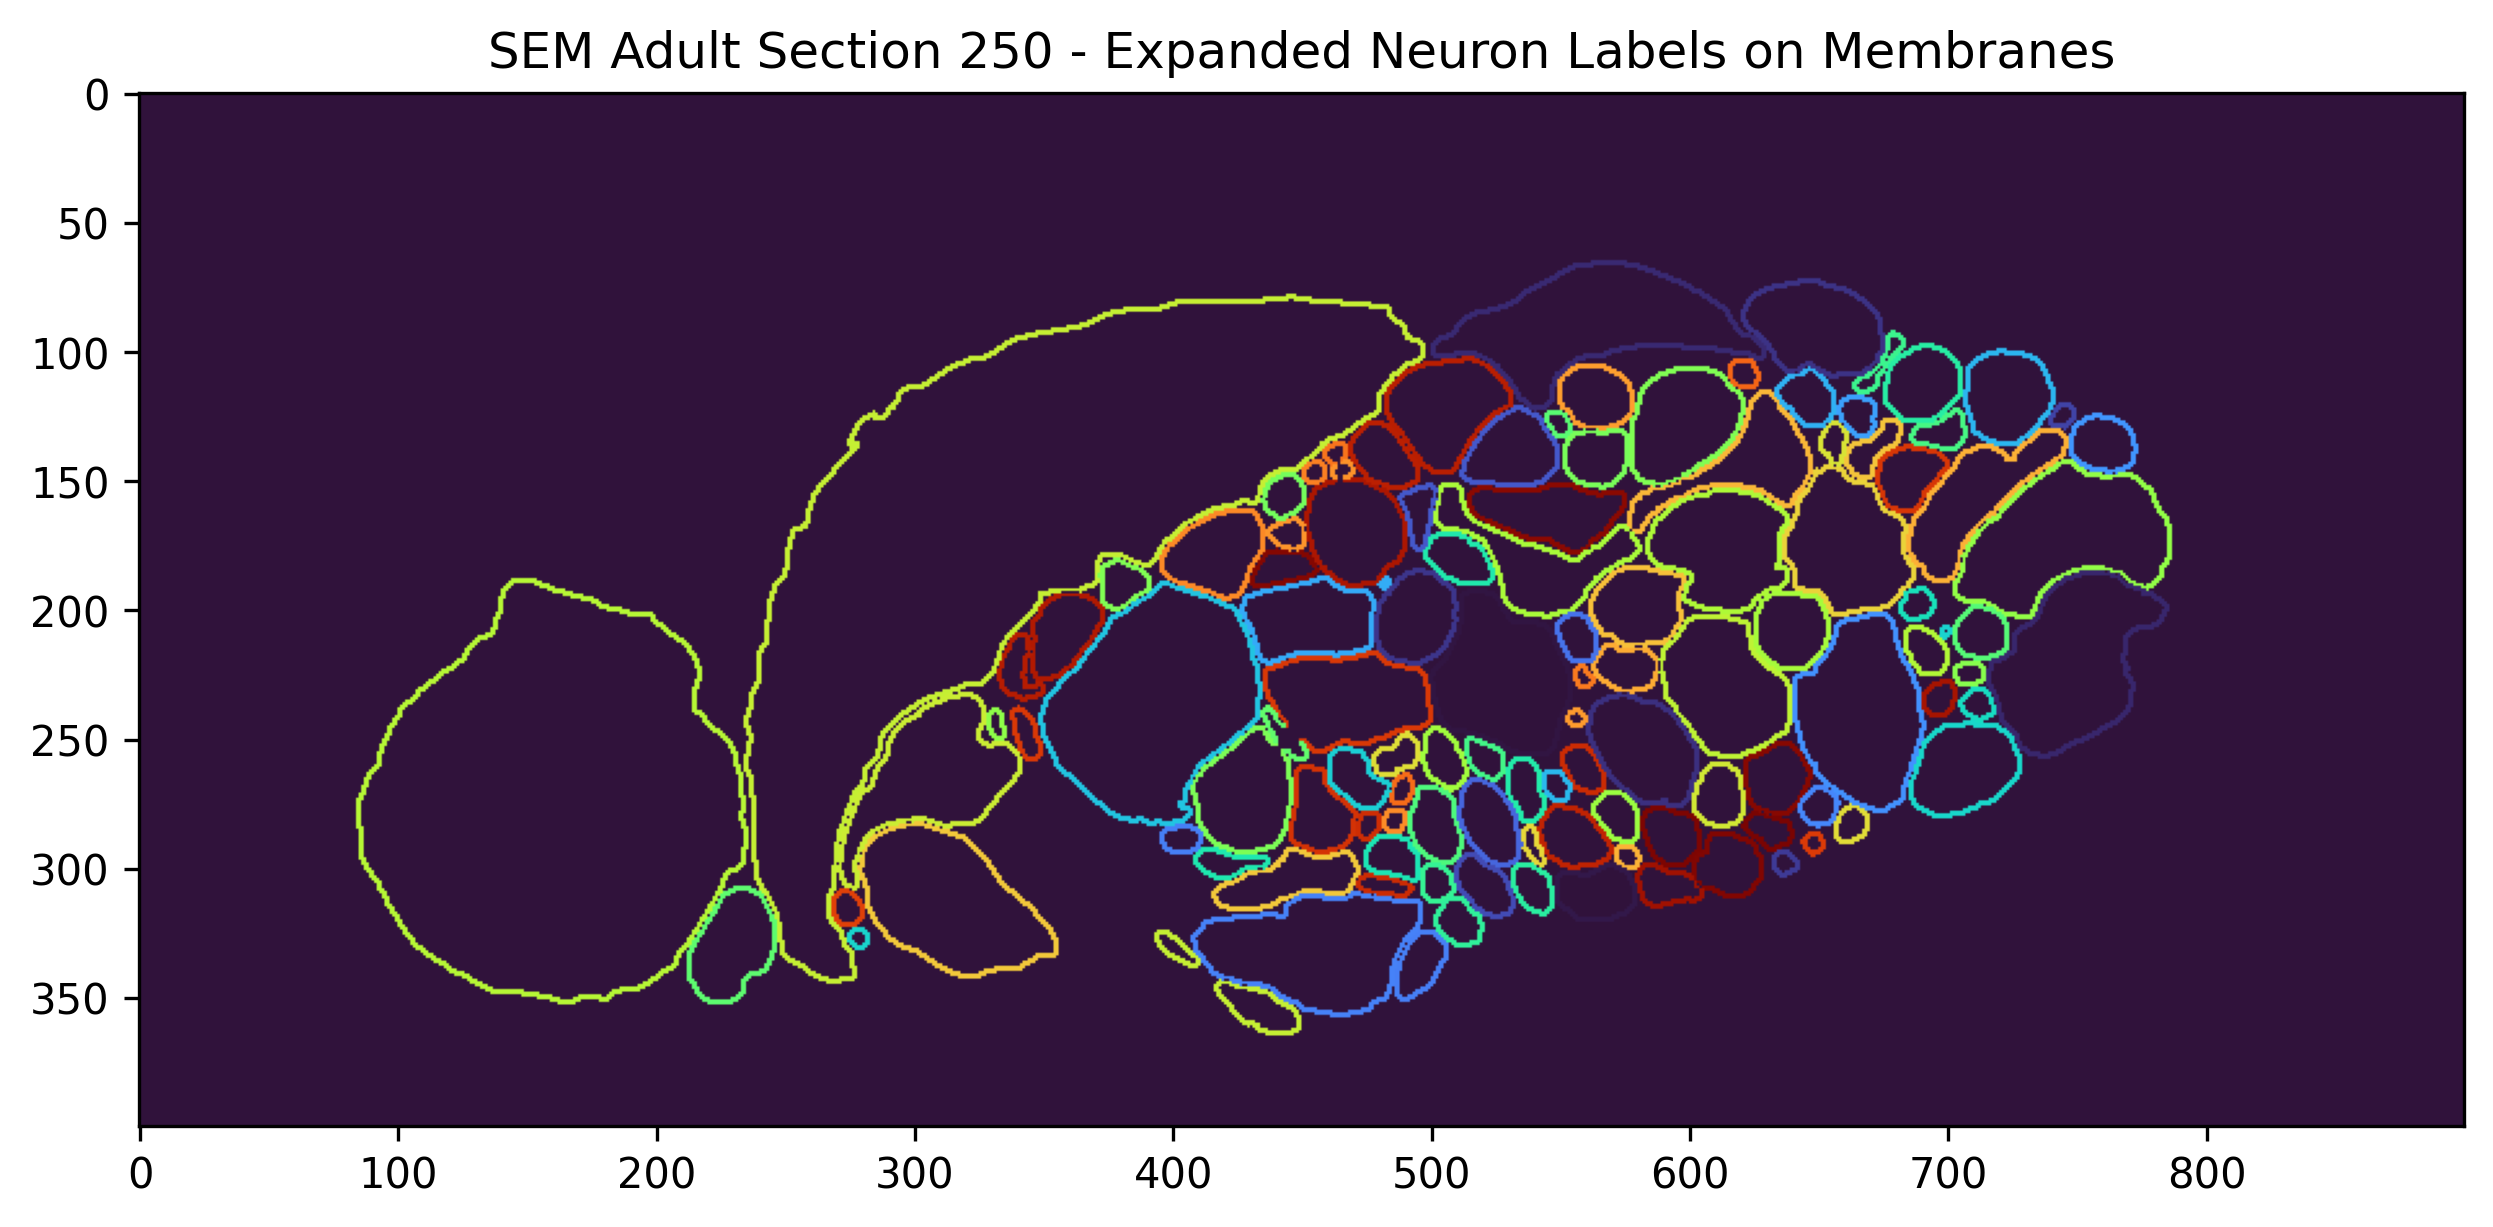

In [ ]:
#Expanded neuron labels on membranes
plt.figure(figsize=(10,10), dpi=300)
plt.title('SEM Adult Section 250 - Expanded Neuron Labels on Membranes')
plt.imshow(L[850:1250, 1700:2600], cmap='turbo')

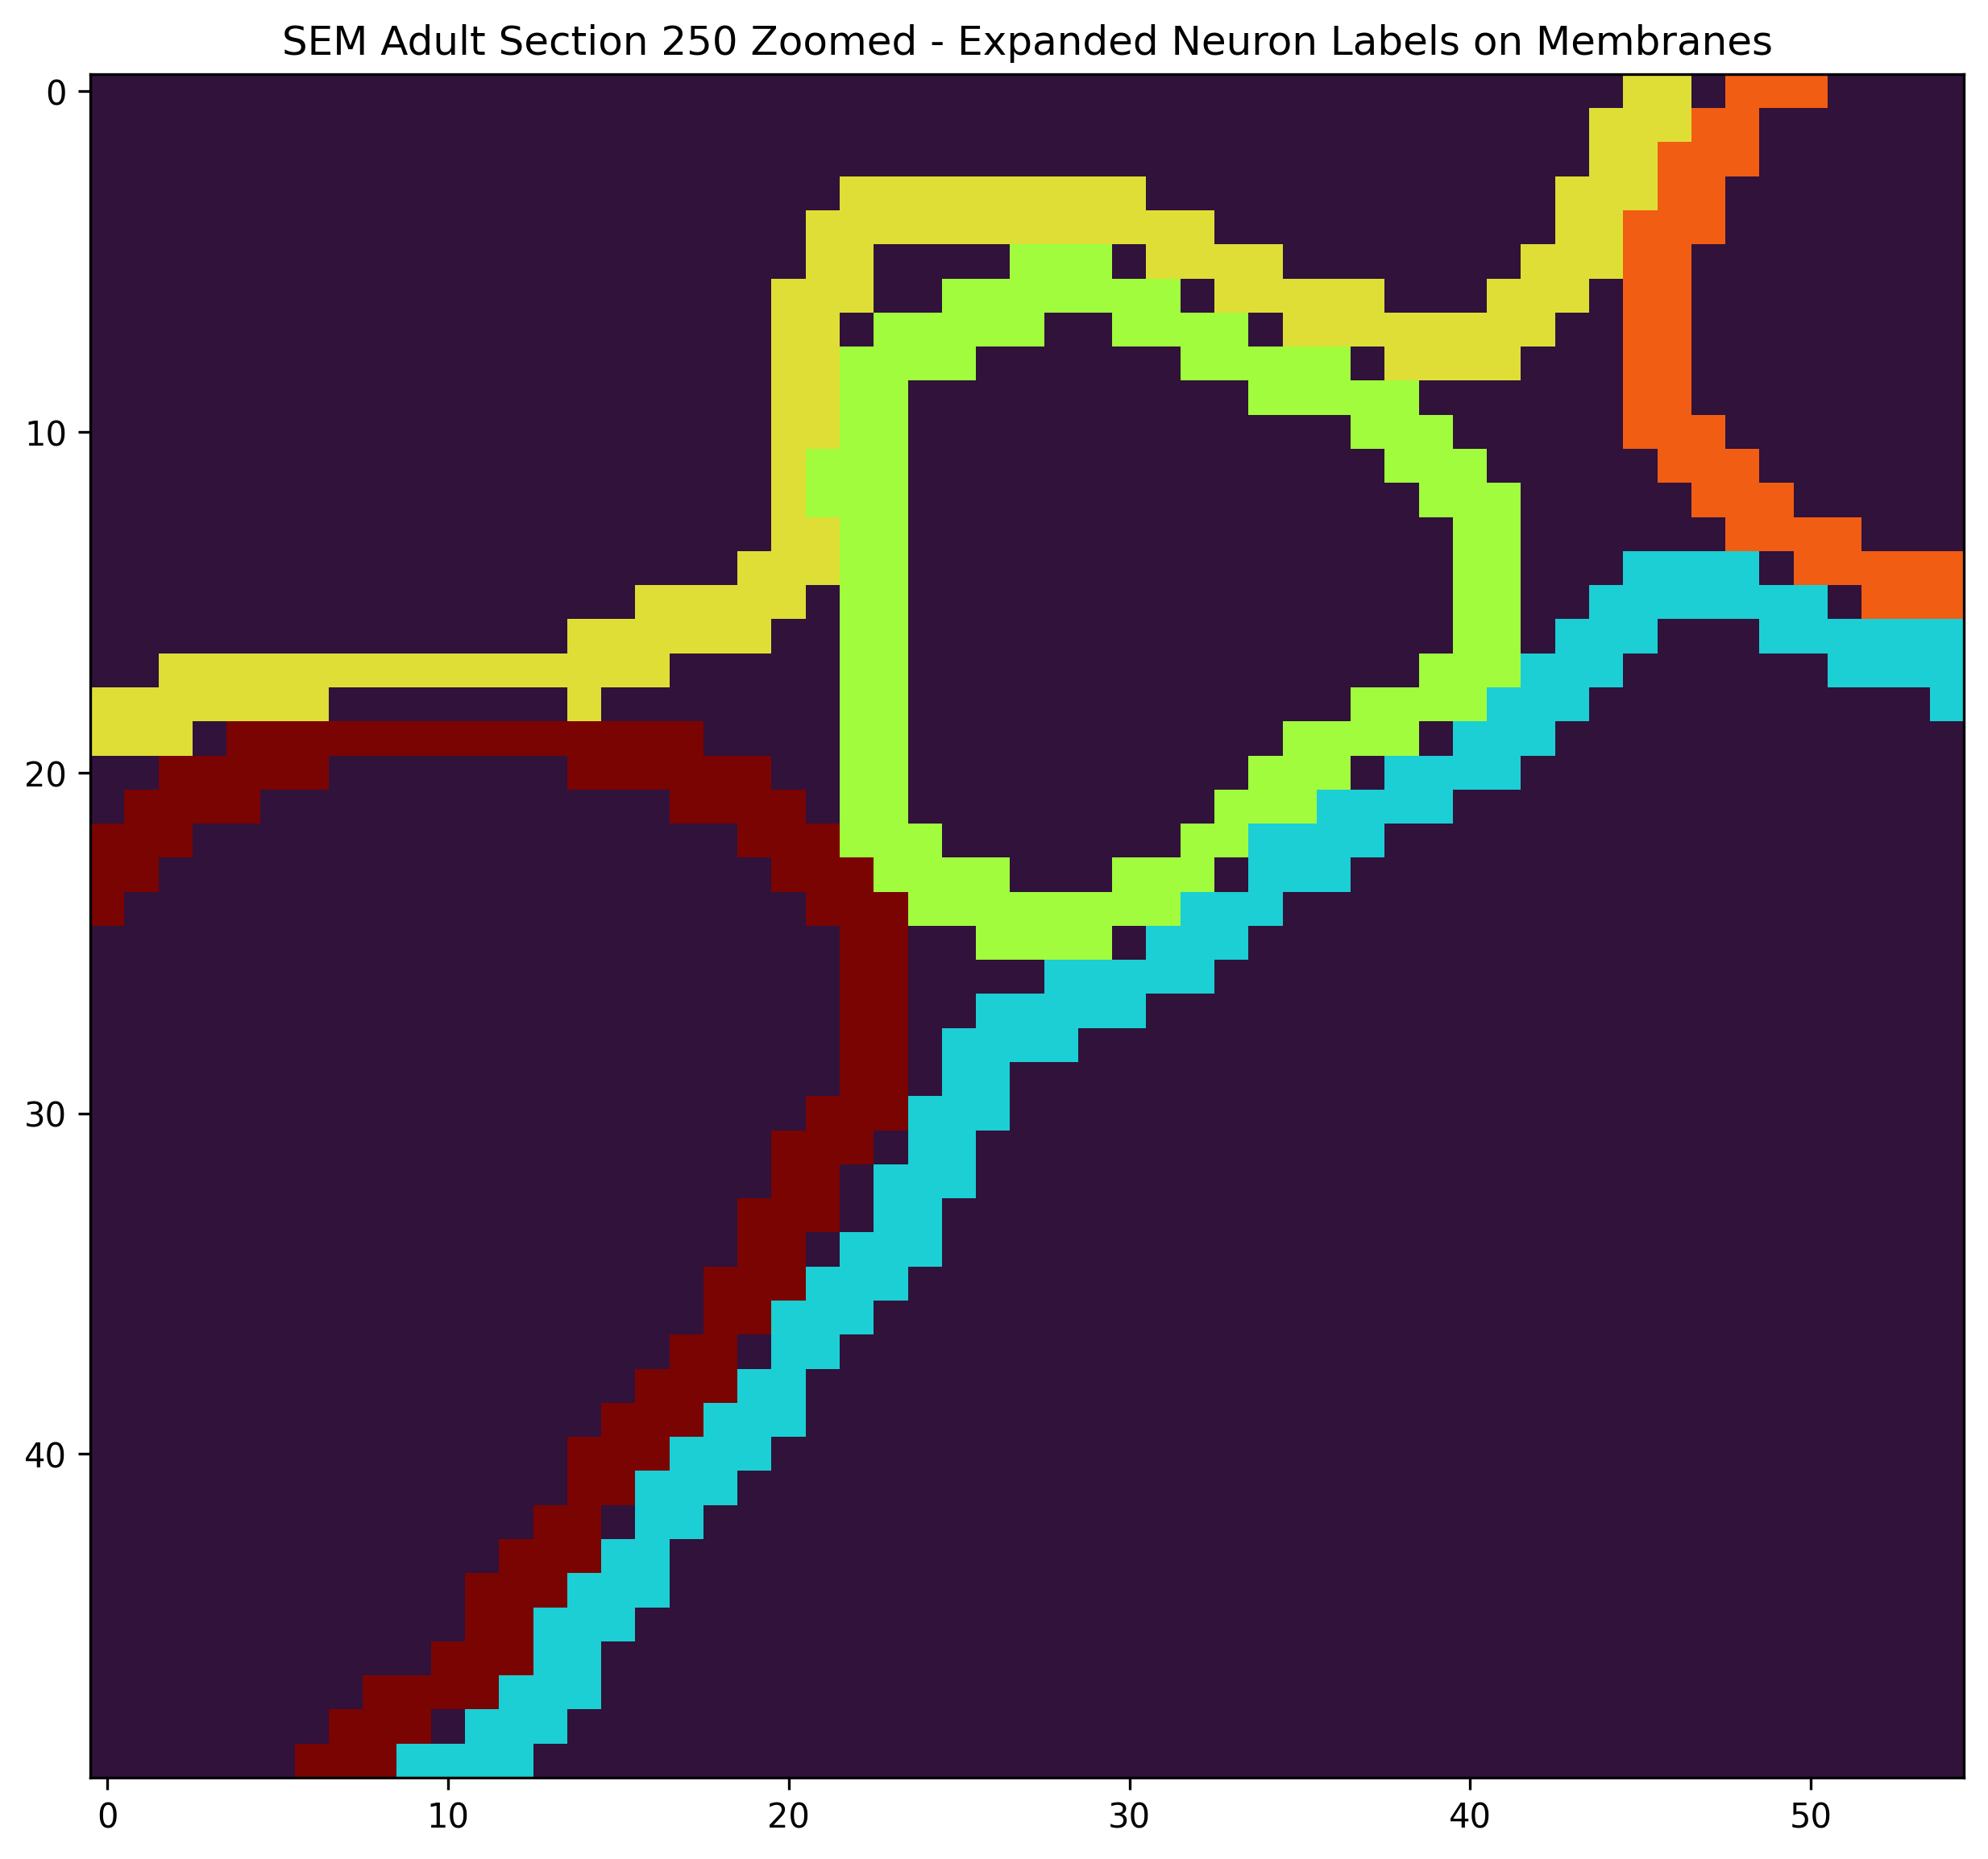

In [52]:
#Expanded neuron labels on membranes
plt.figure(figsize=(10,10), dpi=300)
plt.title('SEM Adult Section 250 Zoomed - Expanded Neuron Labels on Membranes')
plt.imshow(L[1025:1075, 2050:2105], cmap='turbo')

#### Membrane Adjacencies

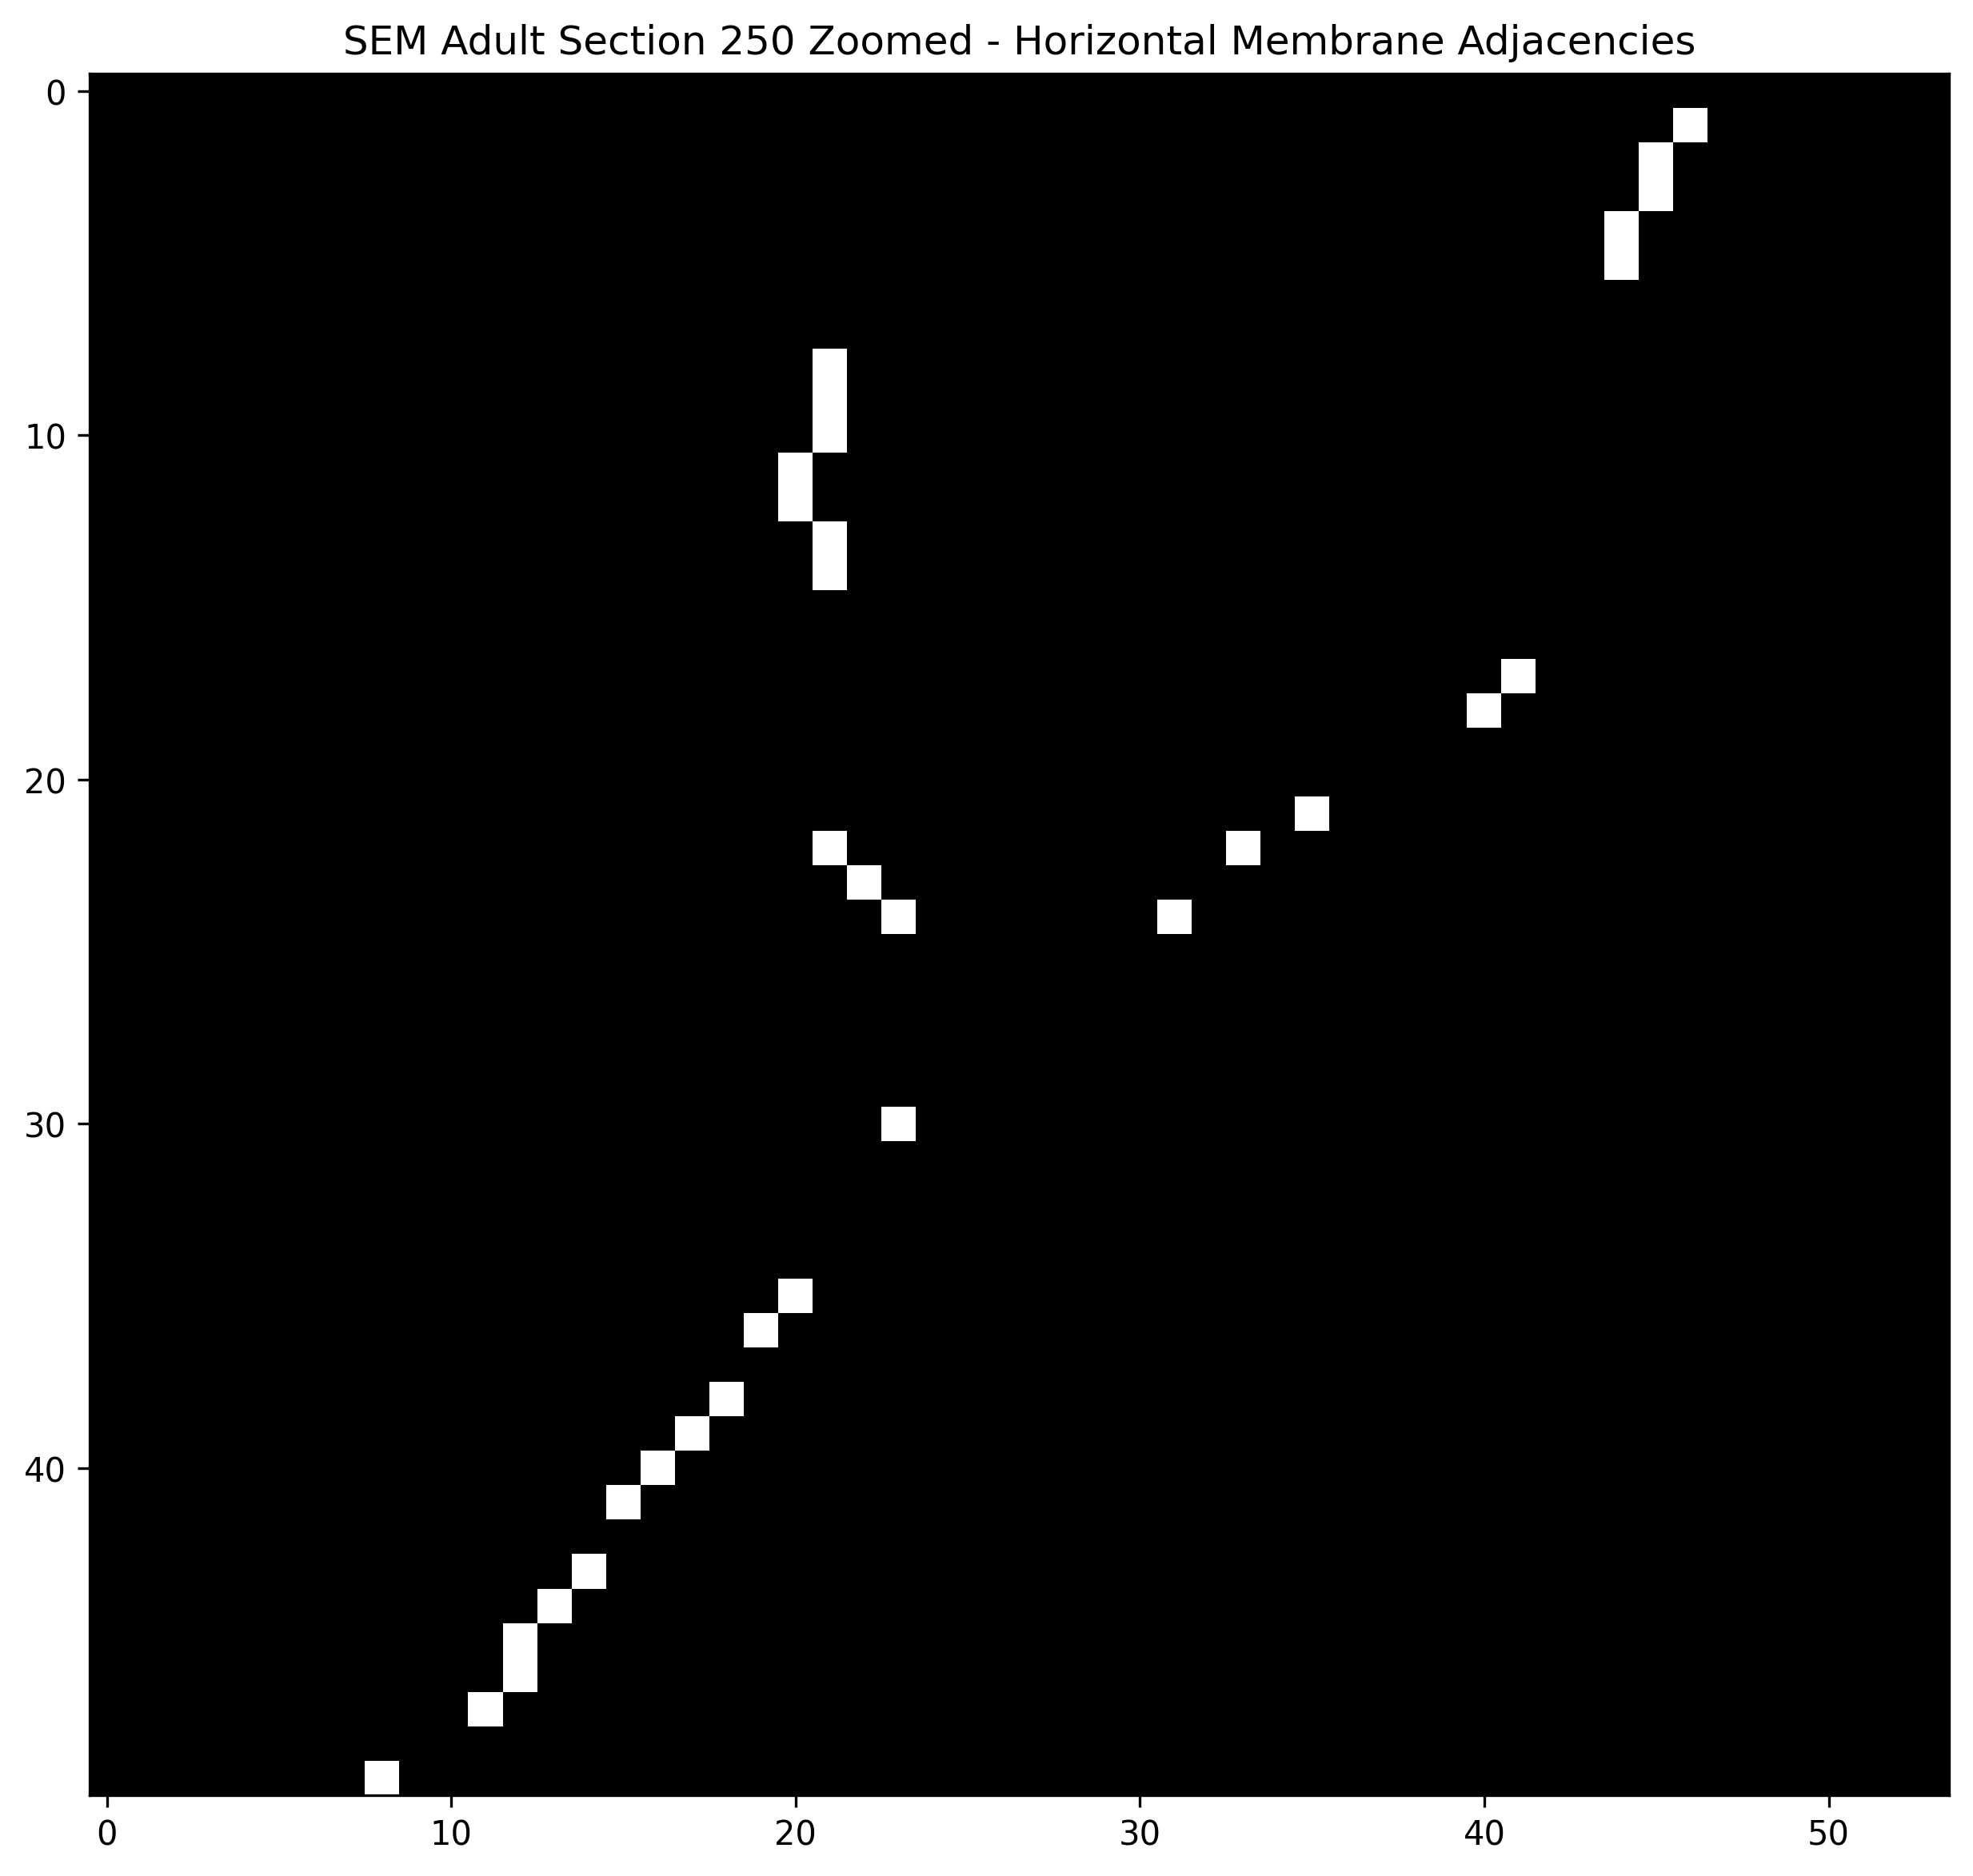

In [55]:
#Horizontal
L_zoomed = L[1025:1075, 2050:2105]
left = L_zoomed[:, :-1]  # All pixels except the rightmost column
right = L_zoomed[:, 1:]  # All pixels except the leftmost column
m = (left > 0) & (right > 0) & (left != right)
plt.figure(figsize=(10,10), dpi=300)
plt.title('SEM Adult Section 250 Zoomed - Horizontal Membrane Adjacencies')
plt.imshow(m, cmap='gray')

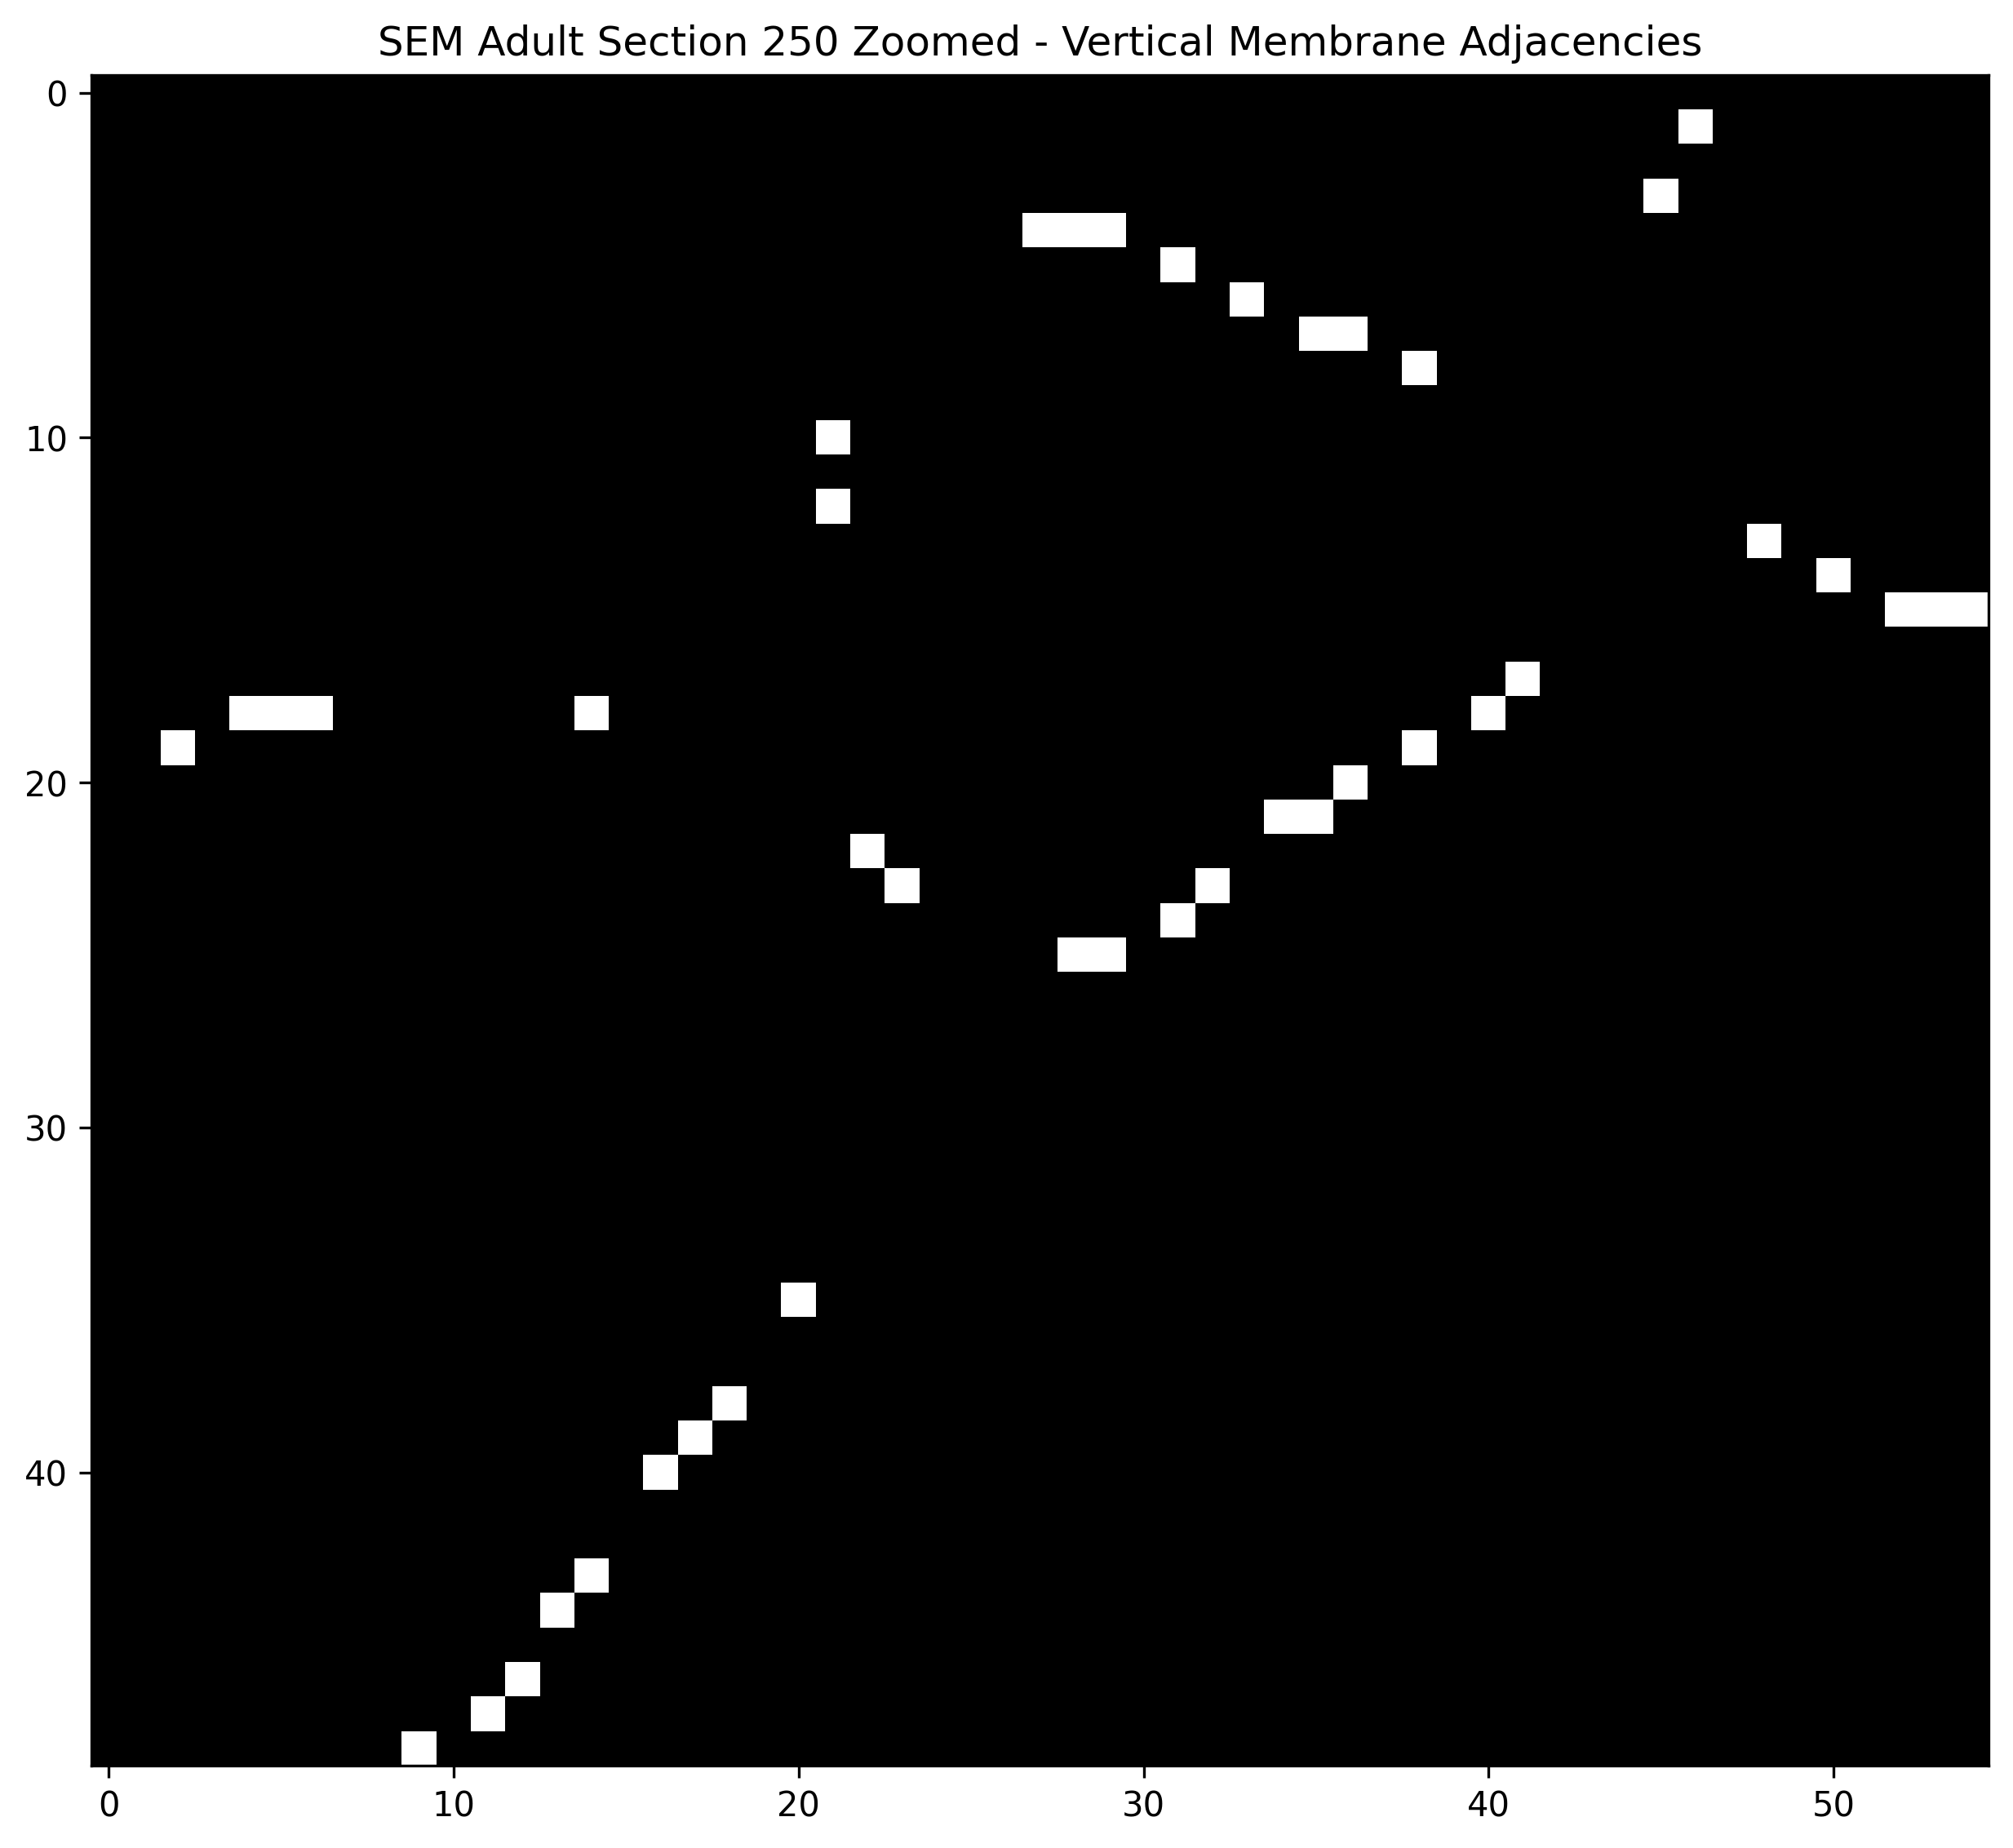

In [56]:
#Vertical
up = L_zoomed[:-1, :]
down = L_zoomed[1:, :]
m = (up > 0) & (down > 0) & (up != down)
plt.figure(figsize=(10,10), dpi=300)
plt.title('SEM Adult Section 250 Zoomed - Vertical Membrane Adjacencies')
plt.imshow(m, cmap='gray')

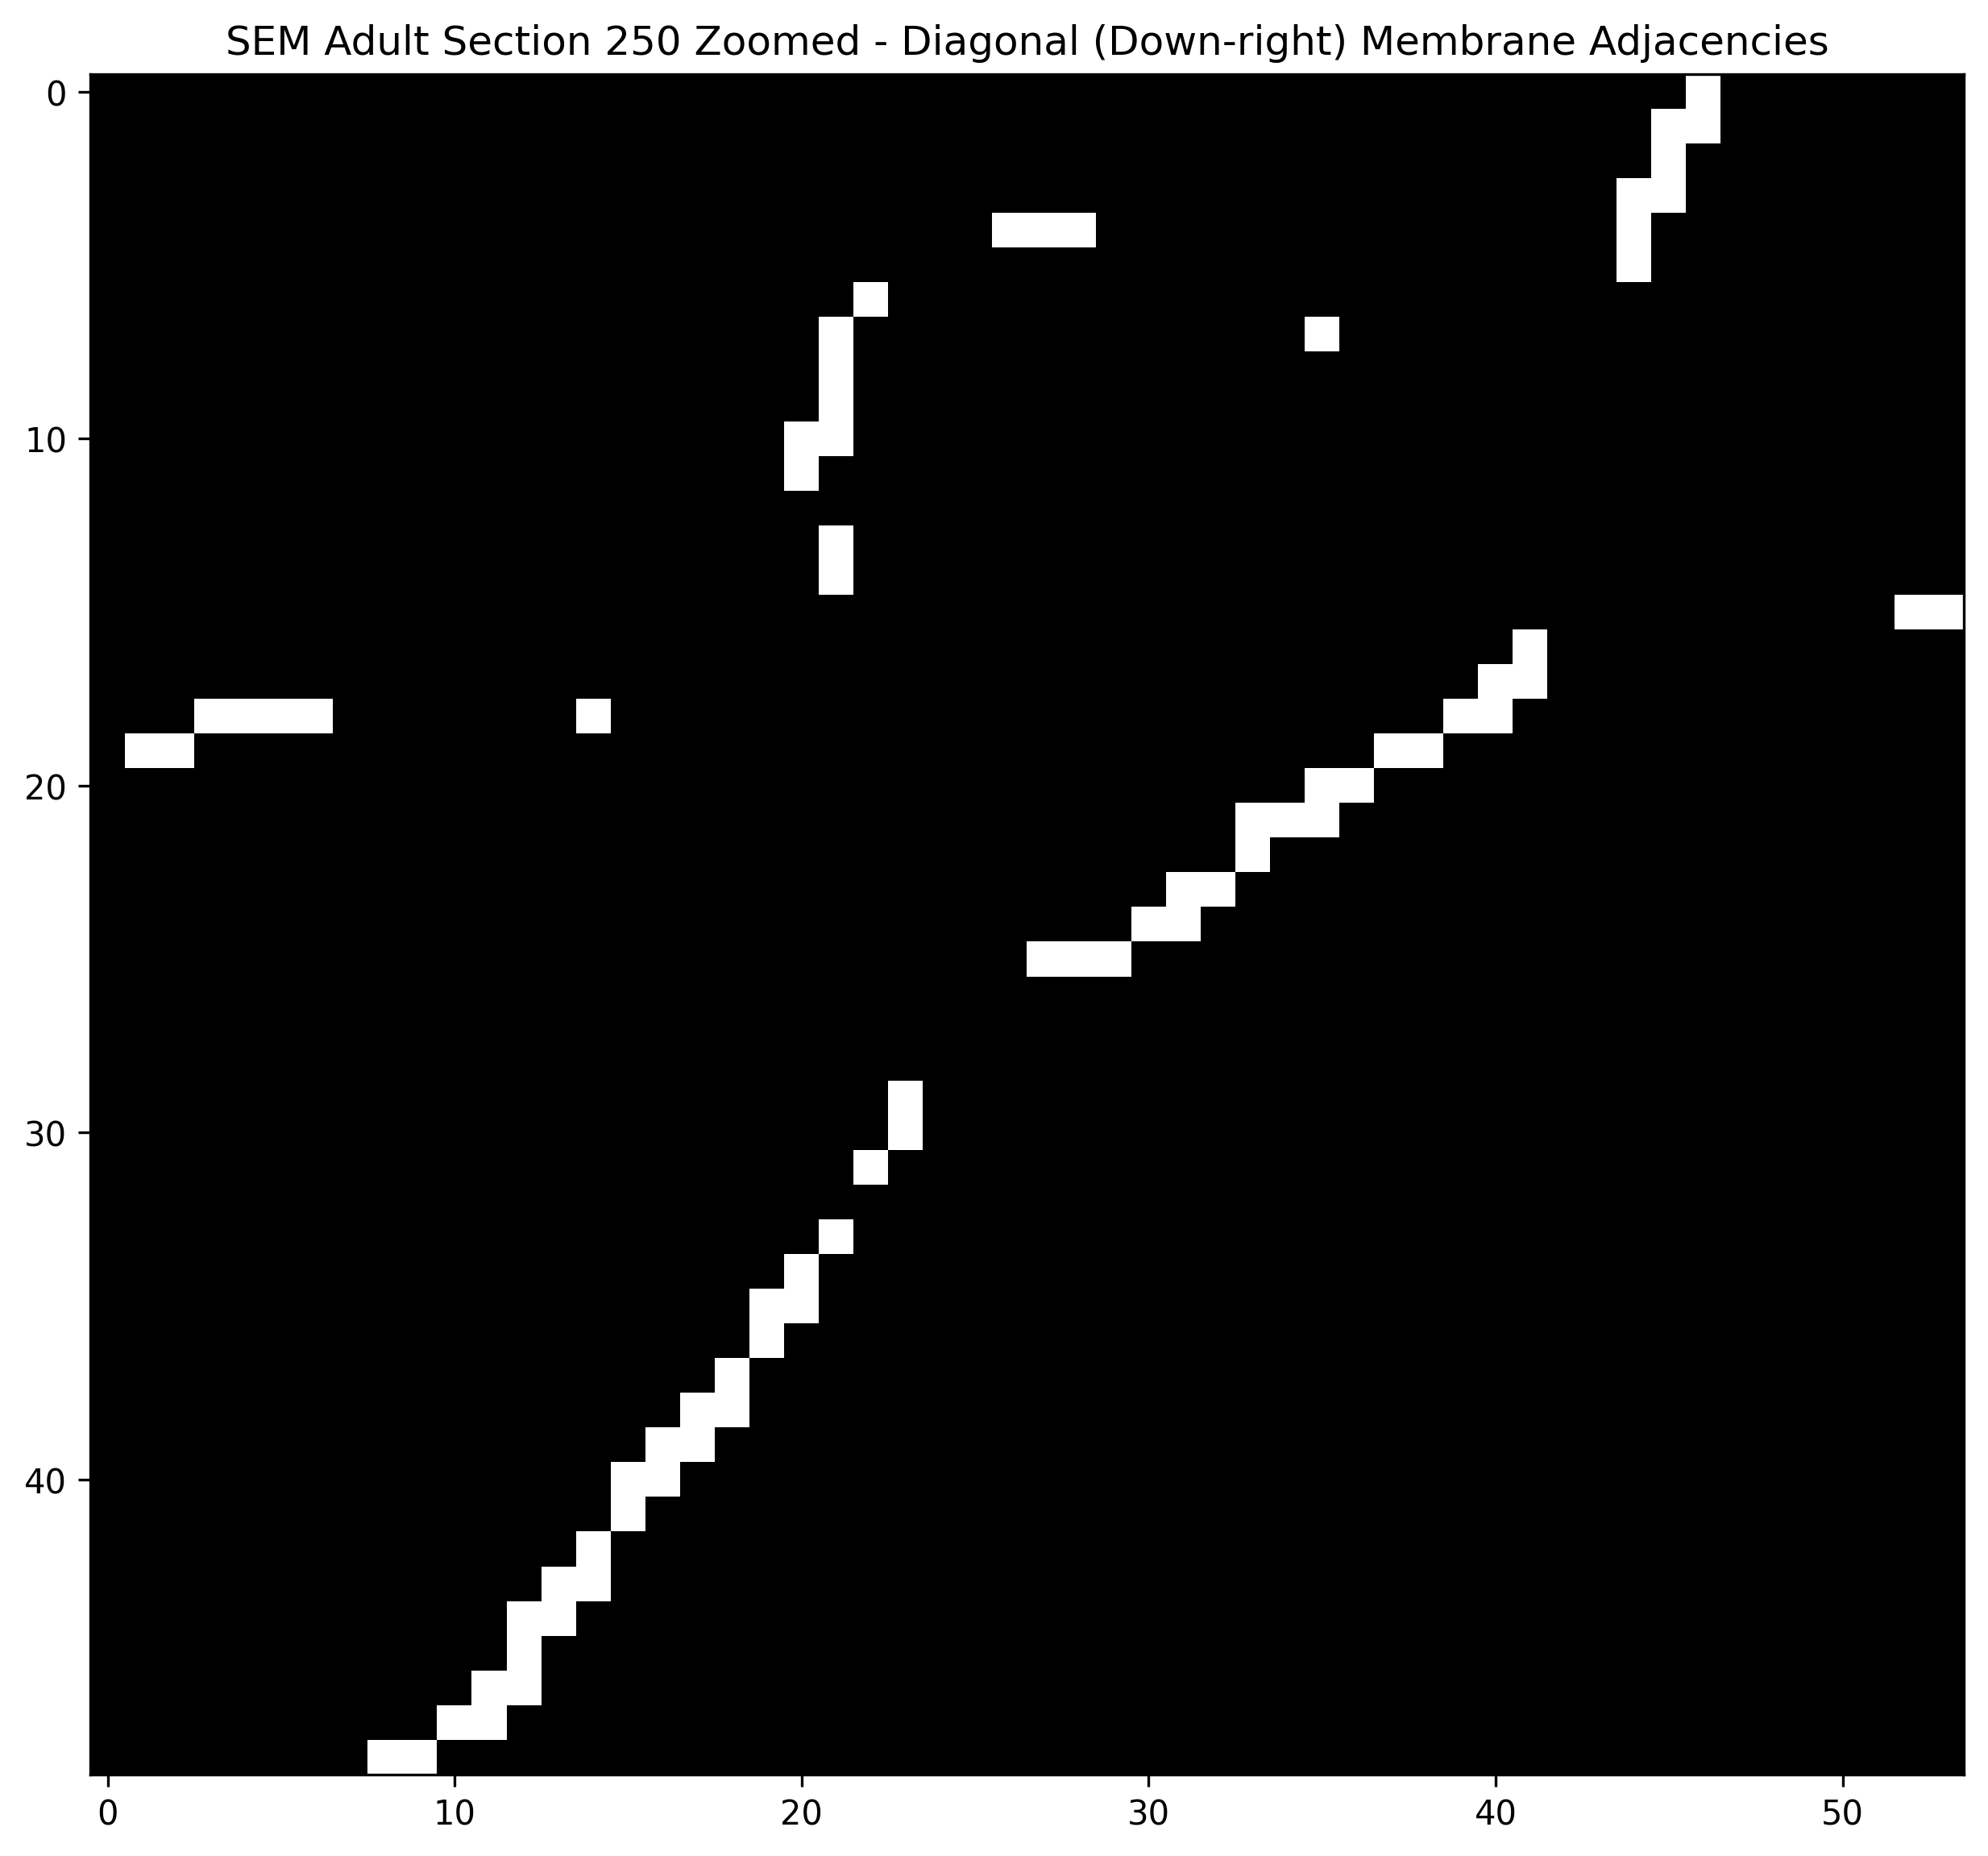

In [57]:
#Diagonal (down-right)
ul = L_zoomed[:-1, :-1]
dr = L_zoomed[1:, 1:]
m = (ul > 0) & (dr > 0) & (ul != dr)
plt.figure(figsize=(10,10), dpi=300)
plt.title('SEM Adult Section 250 Zoomed - Diagonal (Down-right) Membrane Adjacencies')
plt.imshow(m, cmap='gray')

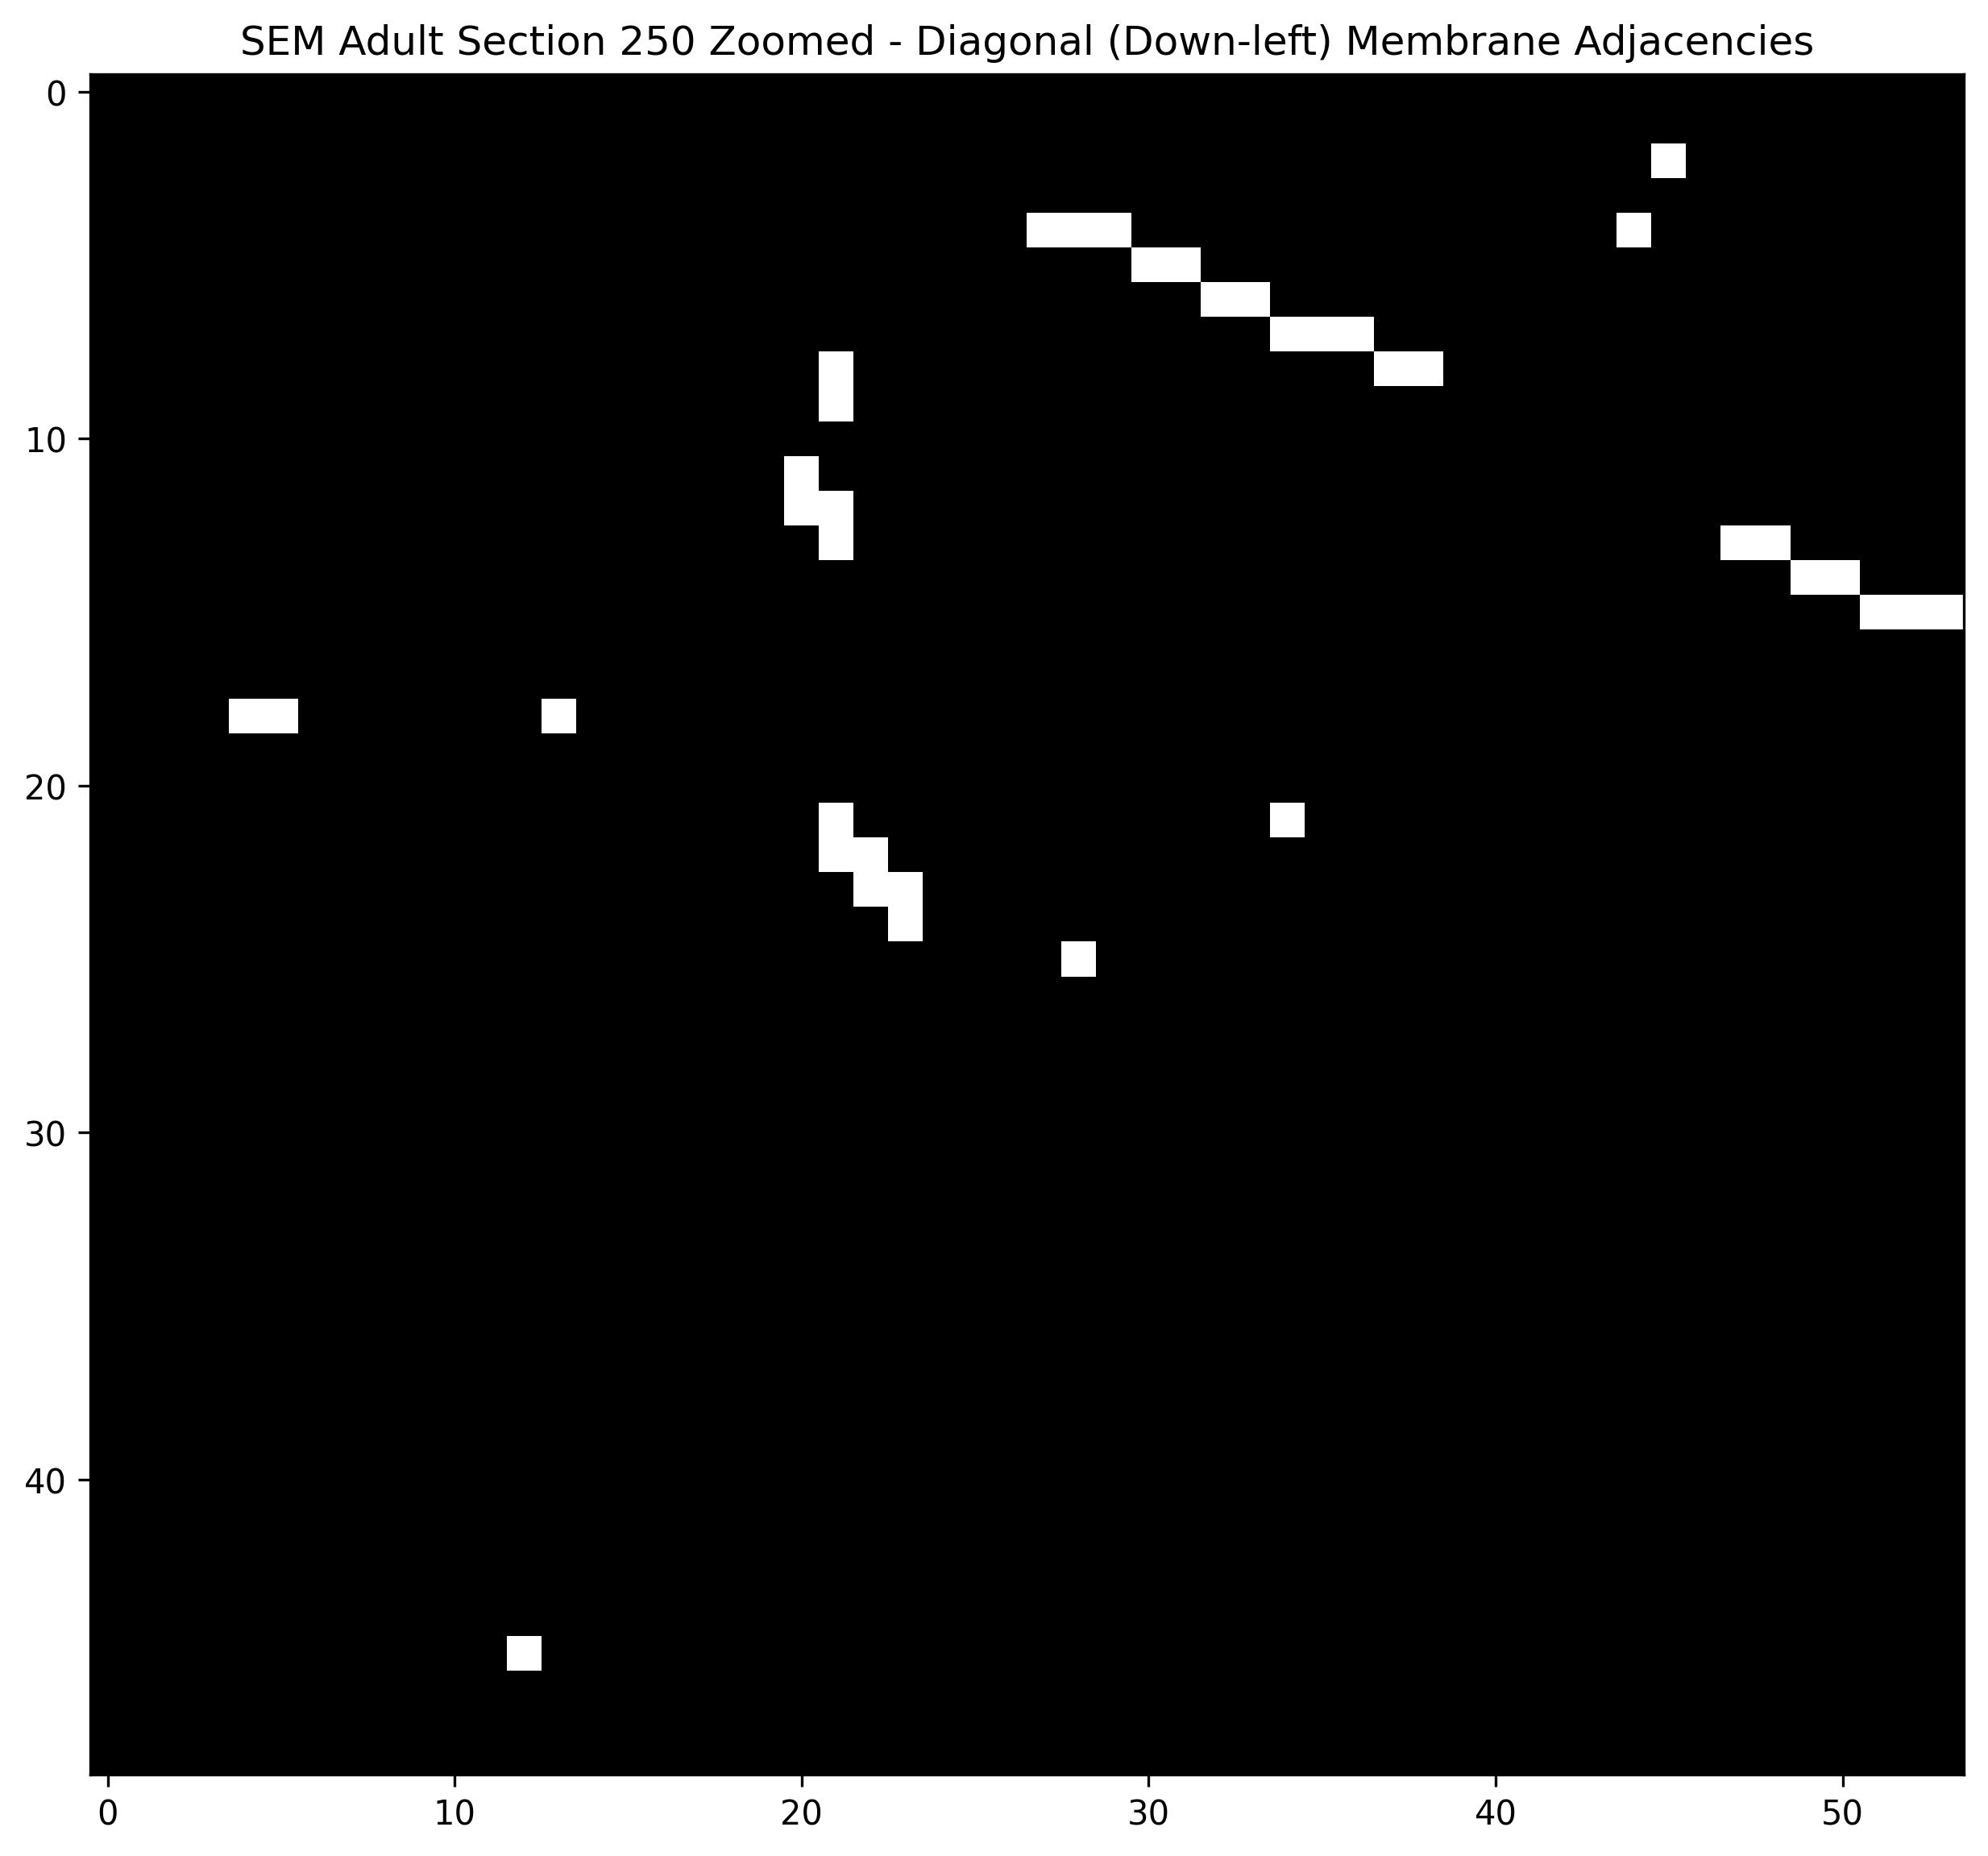

In [58]:
#Diagonal (down-left)
ur = L_zoomed[:-1, 1:]
dl = L_zoomed[1:, :-1]
m = (ur > 0) & (dl > 0) & (ur != dl)
plt.figure(figsize=(10,10), dpi=300)
plt.title('SEM Adult Section 250 Zoomed - Diagonal (Down-left) Membrane Adjacencies')
plt.imshow(m, cmap='gray')